In [230]:
import os
import sys
par_path = '/home/itamar/thesis/FacialLandmarkDetectionThesis'
os.chdir(par_path)
sys.path.append(par_path)
from main.top_level import TopLevel
from main.components.evaluator import Evaluator
import torch
from main.core.functions import inference
import numpy as np
import matplotlib.pyplot as plt
from utils.plot_utils import renorm_image
import torch.nn.functional as F
%matplotlib inline

task_id = 'b8295717f57f4fde82254aa6a97d8f0e'

In [209]:
tl = TopLevel()
tl.init(task_id=task_id)
tl.setup_workspace()
lmd_eval = Evaluator(params=tl.params, logger_cml=tl.task.logger, task_id=tl.task.task_id)

Number of train images : 7862
Number of valid images : 1965
Loading TRANSPOSE Model
:: conv1.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.bias is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.running_mean is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.running_var is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.num_batches_tracked is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: conv2.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn2.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn2.bias is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn2.run

100%|██████████████████████████████████████████████████████████████████████████████| 967/967 [00:13<00:00, 72.92it/s]


In [210]:
res, dataset_eval = dict(), dict()
lmd_eval.model.eval()
lmd_eval.model.to(lmd_eval.device)

test_loader = lmd_eval.create_test_data_loader(dataset='300W')


In [211]:
np_detached = lambda x: x.cpu().detach() if not isinstance(x, np.ndarray) else x
item = next(iter(test_loader))

In [212]:
index = [0]
item['img'].shape

torch.Size([16, 3, 128, 128])

In [213]:
index = 0
img = item['img'][index]
input_, tpts = img.unsqueeze(0).cuda(), item['tpts'][index].unsqueeze(0).cuda()
img_viz = renorm_image(img)


In [291]:
model = lmd_eval.model
kwargs = {}

features = []
global_enc_atten_maps = []

feature_hooks = [model.final_layer.register_forward_hook(lambda self, input, output1: features.append(output1))]
# x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

atten_maps_hooks = [model.global_encoder.layers[i].self_attn.register_forward_hook(
    lambda self, input, output: global_enc_atten_maps.append(output[1])) for i in
    range(len(model.global_encoder.layers))]

with torch.no_grad():
    output, preds = inference(model=model, input_batch=input_, **{'model_name': tl.params.train.model})
    [h.remove() for h in feature_hooks]
    [h.remove() for h in atten_maps_hooks]


In [294]:
shape = features[0].shape[-2:]
enc_atten_maps_hwhw = []
for atten_map in global_enc_atten_maps:
    atten_map = atten_map.reshape(shape + shape)
    enc_atten_maps_hwhw.append(atten_map)

attn_layers_num = len(enc_atten_maps_hwhw)
down_rate = img_viz.shape[0] // shape[0]
# query locations are at the coordinate frame of original image
attn_map_pos = tpts[0] / down_rate

    

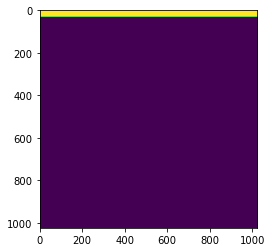

In [329]:
plt.imshow(global_enc_atten_maps[3][0].detach().cpu().numpy())

In [296]:
features[0].shape

torch.Size([1, 68, 32, 32])

In [297]:
# random pos
x1 = img_viz.shape[1] * torch.rand(1)
y1 = img_viz.shape[0] * torch.rand(1)
x2 = img_viz.shape[1] * torch.rand(1)
y2 = img_viz.shape[0] * torch.rand(1)
random_pt_1 = [x1 / down_rate, y1 / down_rate]
random_pt_2 = [x2 / down_rate, y2 / down_rate]
attn_map_pos = attn_map_pos.tolist()
attn_map_pos.append(random_pt_1)
attn_map_pos.append(random_pt_2)


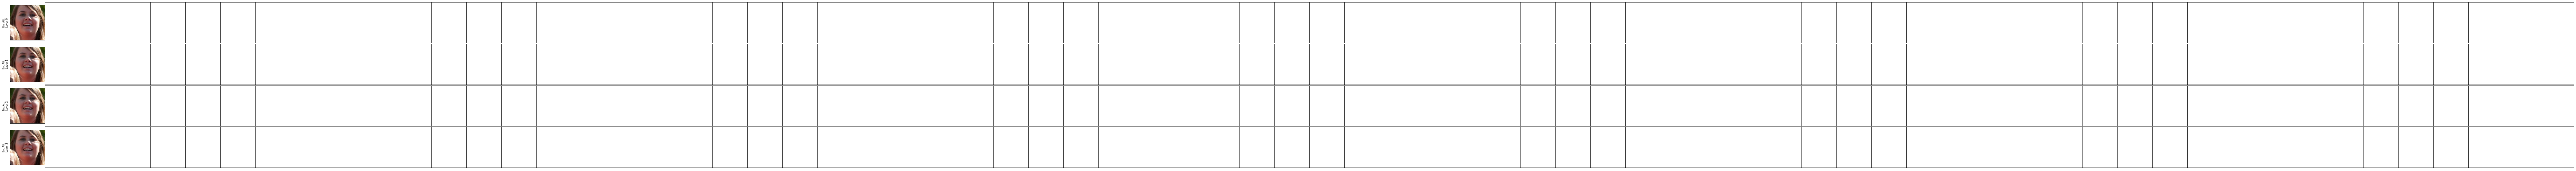

In [298]:
fig, axs = plt.subplots(attn_layers_num, len(attn_map_pos)+3, figsize=(120, 8), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.07, right=0.97, top=0.98, left=0.03, wspace=0.00008, hspace=0.02)
for l in range(attn_layers_num):
    axs[l][0].imshow(img_viz)
    axs[l][0].set_ylabel("Enc.Att.\nLayer {}".format(l), fontsize=8)
    axs[l][0].set_xticks([])
    axs[l][0].set_yticks([])


In [299]:
img_vis_new = img_viz.copy()
for idx, attn_map in enumerate(enc_atten_maps_hwhw):
    for p_id, p in enumerate(attn_map_pos):
        attention_map_for_this_point = F.interpolate(attn_map[None, None, int(p[1]), int(p[0]), :, :],scale_factor=down_rate,mode="bilinear",)[0][0]
        attention_map_for_this_point = (attention_map_for_this_point.squeeze().detach().cpu().numpy())
        x, y = p[0] * down_rate, p[1] * down_rate
        im = axs[idx][p_id + 1].imshow(attention_map_for_this_point, cmap="nipy_spectral", alpha=0.79)

        axs[idx][p_id+1].imshow(img_vis_new)
        
        axs[idx][p_id + 1].scatter(x=x, y=y, s=50, marker="*", c='red')
        # axs[idx][p_id + 1].set_xticks([])
        # axs[idx][p_id + 1].set_yticks([])

        if idx == attn_layers_num - 1:
            axs[idx][p_id + 1].set_xlabel(f"{p_id}", fontsize=25, )
            
cb = fig.colorbar(im, cax=cax, ax=axs, orientation="vertical", fraction=0.05, aspect=50)
plt.savefig("attention_map_{}_{}_{}.jpg".format('aaa', 'aaa', 'a'))

<Figure size 432x288 with 0 Axes>

In [316]:
all(attn_map[0] == 0.001)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

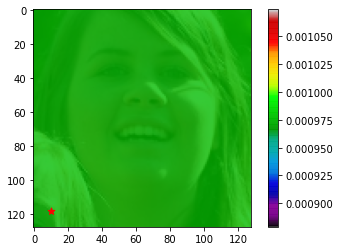

In [305]:
plt.figure()
plt.imshow(img_vis_new)
plt.imshow(attention_map_for_this_point, cmap="nipy_spectral", alpha=0.79)
plt.colorbar()
plt.scatter(x=x, y=y, s=50, marker="*", c='red')
plt.show()

In [306]:
x, y = p[0] * down_rate, p[1] * down_rate

In [308]:
x, y

(tensor([9.9745]), tensor([118.1269]))

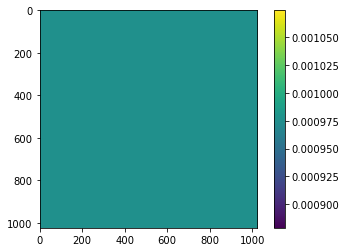

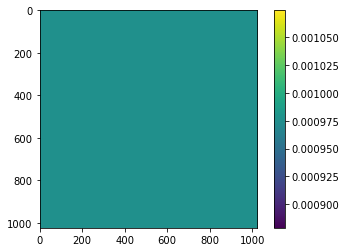

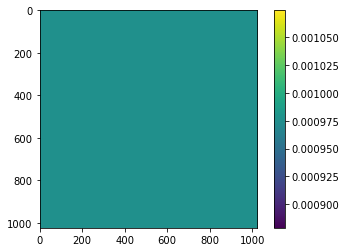

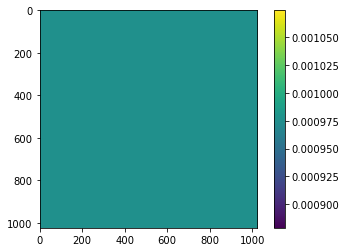

In [301]:
for enc_atten_maps_hwhw_i in enc_atten_maps_hwhw:
    a = enc_atten_maps_hwhw_i.detach().cpu().numpy()
    plt.imshow(np.vstack(np.stack(np.vstack(a), -1)))
    plt.colorbar()
    plt.pause(0.01)

In [281]:
(enc_atten_maps_hwhw_i == enc_atten_maps_hwhw_i[0][0]).detach().cpu().numpy().all()

True

In [282]:
down_rate

4